# Google Play Store Rating Prediction
Data from https://www.kaggle.com/lava18/google-play-store-apps


For Frontier Technology UPH 2019/2020


By: 
- Johny Huang 010821700004
- Eugene Sebastian 01082170027
- Nicholas Chen 010821700

## Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import random
import matplotlib.pyplot as plt
%matplotlib inline

## READ FILE

In [2]:
df = pd.read_csv("googleplaystore.csv")
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## Data information


There are 10841 rows of data before cleansing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
App               10841 non-null object
Category          10841 non-null object
Rating            9367 non-null float64
Reviews           10841 non-null object
Size              10841 non-null object
Installs          10841 non-null object
Type              10840 non-null object
Price             10841 non-null object
Content Rating    10840 non-null object
Genres            10841 non-null object
Last Updated      10841 non-null object
Current Ver       10833 non-null object
Android Ver       10838 non-null object
dtypes: float64(1), object(12)
memory usage: 592.9+ KB


## Removing rows with missing data


There are 9360 rows of data after removing rows with missing data

In [4]:
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
App               9360 non-null object
Category          9360 non-null object
Rating            9360 non-null float64
Reviews           9360 non-null object
Size              9360 non-null object
Installs          9360 non-null object
Type              9360 non-null object
Price             9360 non-null object
Content Rating    9360 non-null object
Genres            9360 non-null object
Last Updated      9360 non-null object
Current Ver       9360 non-null object
Android Ver       9360 non-null object
dtypes: float64(1), object(12)
memory usage: 585.0+ KB


## Cleansing

Transforming size into a uniform format.


The data is currently still in "MB" and "kB" form. 


i.e. 1000MB or 100kB


Data in MB form is multiplied by 1000000 and kB by 1000 to get the size in bytes.


There are also data with "Varies with device". For these data it is imputted with the pandas function fillna with the method ffill, which imputs the data with the data from the previous row

In [5]:
def change_size(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None

df["Size"] = df["Size"].map(change_size)

#filling Size which had NA
df.Size.fillna(method = 'ffill', inplace = True)

Transforms types into a binary format


The current data are now either "Free" or "Paid"


Free is converted to 0, and Paid is converted to 1

In [6]:
def type_cat(types):
    if types == 'Free':
        return 0
    else:
        return 1

df['Type'] = df['Type'].map(type_cat)

Transforming Content Rating label to content_rating for easier handling


There is a single row of data with the data "Unrated", therefore we drop this data as it can't be used

In [7]:
df.rename( columns={
    'Content Rating': 'content_rating'
}, inplace=True)
df = df[df.content_rating != 'Unrated']

We drop some features that most likely doesn't affect the prediction such as "Last Updated", "Current Ver", "Android Ver", "App", "Installs", and "Reviews". This is because when we predict for the rating we can't input the installs or reviews of our app before we actually have it on the Google Play Store.

In [8]:
df.drop(labels = ['Last Updated','Current Ver','Android Ver','App','Installs','Reviews'], axis = 1, inplace = True)

Transform the price into float value


The current data which is currently in "$" form or "0"


i.e. $4.99


We remove the "$" and convert the data into a float data type

In [9]:
def price_clean(price):
    if price == '0':
        return 0
    else:
        price = price[1:]
        price = float(price)
        return price

df['Price'] = df['Price'].map(price_clean).astype(float)

Result after cleansing

In [10]:
df.head()

,Category,Rating,Size,Type,Price,content_rating,Genres
0,ART_AND_DESIGN,4.1,19000000.0,0,0.0,Everyone,Art & Design
1,ART_AND_DESIGN,3.9,14000000.0,0,0.0,Everyone,Art & Design;Pretend Play
2,ART_AND_DESIGN,4.7,8700000.0,0,0.0,Everyone,Art & Design
3,ART_AND_DESIGN,4.5,25000000.0,0,0.0,Teen,Art & Design
4,ART_AND_DESIGN,4.3,2800000.0,0,0.0,Everyone,Art & Design;Creativity


## Feature Encoding

Since models doesn't accept string data types, we need to convert our string data types into an acceptable format. There are 3 features which we are encoding in this section which are "Category", "content_rating" and "Genres". These features are categorical data and to convert them into numerical data there are several methods such as Label Encoding and One Hot Encoding.


We use One Hot Encoding over Label Encoding for our features because with Label Encoding the machine learning algorithm may "misinterpret" the numerical value of the encoded data so that one is more significant than the other, even though it may not be the case.


One Hot Encoding seperates each unique data in our feature into a seperate column. If the data corresponds to that column, then its value is one, otherwise it is 0.

For "Genres" because there are several data with multiple genres such as "Art & Design;Pretend Play" we encode it so that both Art & Design and Pretend Play has the value 1.

In [11]:
ohe = df['Genres'].str.get_dummies(';')
pd.set_option('display.max_columns', 500)
df = df.join(ohe)
df = df.drop(columns=['Genres'])
df.head()

,Category,Rating,Size,Type,Price,content_rating,Action,Action & Adventure,Adventure,Arcade,Art & Design,Auto & Vehicles,Beauty,Board,Books & Reference,Brain Games,Business,Card,Casino,Casual,Comics,Communication,Creativity,Dating,Education,Educational,Entertainment,Events,Finance,Food & Drink,Health & Fitness,House & Home,Libraries & Demo,Lifestyle,Maps & Navigation,Medical,Music,Music & Audio,Music & Video,News & Magazines,Parenting,Personalization,Photography,Pretend Play,Productivity,Puzzle,Racing,Role Playing,Shopping,Simulation,Social,Sports,Strategy,Tools,Travel & Local,Trivia,Video Players & Editors,Weather,Word
0,ART_AND_DESIGN,4.1,19000000.0,0,0.0,Everyone,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ART_AND_DESIGN,3.9,14000000.0,0,0.0,Everyone,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ART_AND_DESIGN,4.7,8700000.0,0,0.0,Everyone,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ART_AND_DESIGN,4.5,25000000.0,0,0.0,Teen,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ART_AND_DESIGN,4.3,2800000.0,0,0.0,Everyone,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


For "Category" and "content_rating" we can simple use pandas get_dummies function to seperate each unique data into a column

In [12]:
df = pd.get_dummies(df, columns=['Category', 'content_rating'])
df.head()

,Rating,Size,Type,Price,Action,Action & Adventure,Adventure,Arcade,Art & Design,Auto & Vehicles,Beauty,Board,Books & Reference,Brain Games,Business,Card,Casino,Casual,Comics,Communication,Creativity,Dating,Education,Educational,Entertainment,Events,Finance,Food & Drink,Health & Fitness,House & Home,Libraries & Demo,Lifestyle,Maps & Navigation,Medical,Music,Music & Audio,Music & Video,News & Magazines,Parenting,Personalization,Photography,Pretend Play,Productivity,Puzzle,Racing,Role Playing,Shopping,Simulation,Social,Sports,Strategy,Tools,Travel & Local,Trivia,Video Players & Editors,Weather,Word,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,content_rating_Adults only 18+,content_rating_Everyone,content_rating_Everyone 10+,content_rating_Mature 17+,content_rating_Teen
0,4.1,19000000.0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,3.9,14000000.0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,4.7,8700000.0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,4.5,25000000.0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,4.3,2800000.0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## Training, Testing and Validation

Here we define which columns are features in X and label in Y. The label is Rating, and features are the rest of the columns

In [13]:
X = df.drop(columns=['Rating'], axis=1)
y = df.Rating

### Linear Regression


We split the data into training, testing and validation data with a ratio of 3/5, 1/5 and 1/5. We then input the training data into the Linear Regression algorithm to get the model, and save the training model into pickle. Then we test the model with our test data.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=1)
model = LinearRegression()
model.fit(X_train,y_train)
#with open("LogRegModel.pkl", "wb") as file:
#    pickle.dump(model, file)
Results = model.predict(X_test)
print(Results)

[4.03958041 4.05551751 4.10558132 ... 4.34870678 4.06948995 4.2584719 ]


We evaluate the model by using Mean Absolute Error, Mean Square Error, and R2 Score of the prediction result using the test data and the actual data from the validation data. We get the result as shown below

In [15]:
print("MAE: ", mean_absolute_error(y_val, Results))
print("MSE: ", sqrt(mean_squared_error(y_val, Results)))
print("R2 Score: ", r2_score(y_val, Results))

MAE:  0.3491071751602543
MSE:  0.5006391054430986
R2 Score:  0.03445027542677215


We plot the result of the predicted rating against the real rating below

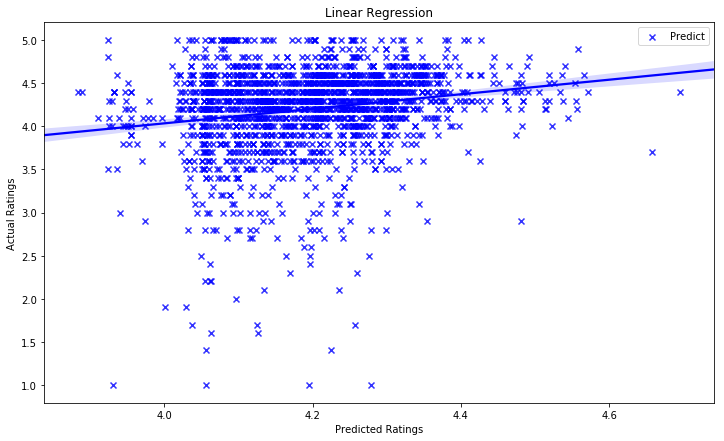

In [16]:
plt.figure(figsize=(12,7))
sns.regplot(Results,y_val,color='blue', label = 'Predict', marker = 'x')
plt.legend()
plt.title('Linear Regression')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [17]:
list(X_test.columns)
data = {'Size': 500000.0, 'Type': 0, 'Price': 0.0, 'Action': 0, 'Action & Adventure': 1, 'Adventure': 1, 'Arcade': 0, 'Art & Design': 0, 'Auto & Vehicles': 0, 'Beauty': 0, 'Board': 0, 'Books & Reference': 0, 'Brain Games': 0, 'Business': 0, 'Card': 0, 'Casino': 0, 'Casual': 0, 'Comics': 0, 'Communication': 0, 'Creativity': 0, 'Dating': 0, 'Education': 0, 'Educational': 0, 'Entertainment': 0, 'Events': 0, 'Finance': 0, 'Food & Drink': 0, 'Health & Fitness': 0, 'House & Home': 0, 'Libraries & Demo': 0, 'Lifestyle': 0, 'Maps & Navigation': 0, 'Medical': 0, 'Music': 0, 'Music & Audio': 0, 'Music & Video': 0, 'News & Magazines': 0, 'Parenting': 0, 'Personalization': 0, 'Photography': 0, 'Pretend Play': 0, 'Productivity': 0, 'Puzzle': 0, 'Racing': 0, 
        'Role Playing': 0, 'Shopping': 0, 'Simulation': 0, 'Social': 0, 'Sports': 0, 'Strategy': 0, 'Tools': 0, 'Travel & Local': 0, 'Trivia': 0, 'Video Players & Editors': 0, 'Weather': 0, 'Word': 0, 'Category_ART_AND_DESIGN': 0, 'Category_AUTO_AND_VEHICLES': 0, 'Category_BEAUTY': 0, 'Category_BOOKS_AND_REFERENCE': 0, 'Category_BUSINESS': 0, 'Category_COMICS': 0, 'Category_COMMUNICATION': 0, 'Category_DATING': 0, 'Category_EDUCATION': 0, 'Category_ENTERTAINMENT': 0, 'Category_ENTERTAINMENT': 0,
         'Category_EVENTS': 0, 'Category_FAMILY': 0, 'Category_FINANCE': 0, 'Category_FOOD_AND_DRINK': 0, 'Category_GAME': 1, 'Category_HEALTH_AND_FITNESS': 0, 'Category_HOUSE_AND_HOME': 0, 'Category_LIBRARIES_AND_DEMO': 0, 'Category_LIFESTYLE': 0, 'Category_MAPS_AND_NAVIGATION': 0, 'Category_MEDICAL': 0, 'Category_NEWS_AND_MAGAZINES': 0, 'Category_PARENTING': 0, 'Category_PERSONALIZATION': 0, 'Category_PHOTOGRAPHY': 0, 'Category_PRODUCTIVITY': 0, 'Category_SHOPPING': 0, 'Category_SOCIAL': 0, 'Category_SPORTS': 0, 'Category_TOOLS': 0, 'Category_TRAVEL_AND_LOCAL': 0, 'Category_VIDEO_PLAYERS': 0, 'Category_WEATHER': 0, 'content_rating_Adults only 18+': 0, 'content_rating_Everyone': 0, 'content_rating_Everyone 10+': 0, 'content_rating_Mature 17+': 0, 'content_rating_Teen': 0}
input_data = pd.DataFrame(data, index=[0])
input_data.head()
print(model.predict(input_data))

[4.29314225]


### Support Vector Regression


Again we split the data into training, testing and validation data with a ratio of 3/5, 1/5 and 1/5. We then input the training data into the Support Vector Regression algorithm to get the model, and save the training model into pickle. Then we test the model with our test data.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=1)
model = svm.SVR()
model.fit(X_train,y_train)
Results = model.predict(X_test)
#with open("SVRModel.pkl", "wb") as file:
#    pickle.dump(model, file)
print(Results)

c:\users\predator\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[4.2032259  4.24652394 4.2306882  ... 4.52212792 4.34734619 4.49956392]


We evaluate the model by using Mean Absolute Error, Mean Square Error, and R2 Score of the prediction result using the test data and the actual data from the validation data. We get the result as shown below

In [19]:
print("MAE: ", mean_absolute_error(y_val, Results))
print("MSE: ", sqrt(mean_squared_error(y_val, Results)))
print("R2 Score: ", r2_score(y_val, Results))

MAE:  0.33811612209260894
MSE:  0.5116359476461729
R2 Score:  -0.008433363636443314


We plot the result of the predicted rating against the real rating below

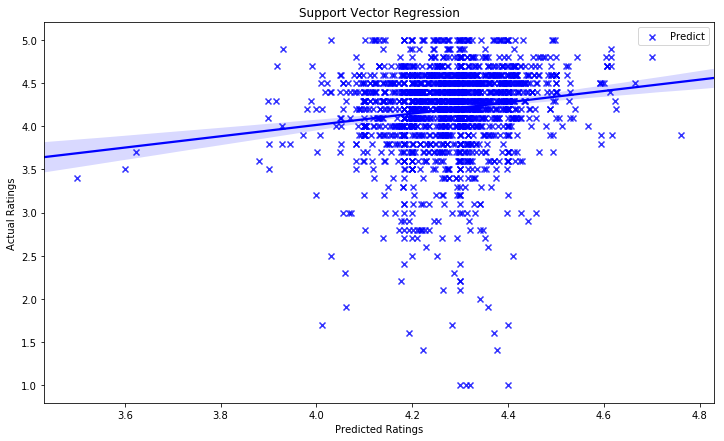

In [20]:
plt.figure(figsize=(12,7))
sns.regplot(Results,y_val,color='blue', label = 'Predict', marker = 'x')
plt.legend()
plt.title('Support Vector Regression')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### Decission Tree Regressor


Again we split the data into training, testing and validation data with a ratio of 3/5, 1/5 and 1/5. We then input the training data into the Decision Tree Regressor algorithm to get the model, and save the training model into pickle. Then we test the model with our test data.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=1)
model = DecisionTreeRegressor(random_state = 0)
model.fit(X_train,y_train)
#with open("DecTreeModel.pkl", "wb") as file:
#    pickle.dump(model, file)
Results = model.predict(X_test)
print(Results)

[3.95 3.9  3.   ... 4.6  4.39 4.65]


We evaluate the model by using Mean Absolute Error, Mean Square Error, and R2 Score of the prediction result using the test data and the actual data from the validation data. We get the result as shown below

In [22]:
print("MAE: ", mean_absolute_error(y_val, Results))
print("MSE: ", sqrt(mean_squared_error(y_val, Results)))
print("R2 Score: ", r2_score(y_val, Results))

MAE:  0.40933616434017084
MSE:  0.6241388817635428
R2 Score:  -0.500678227843321


We plot the result of the predicted rating against the real rating below

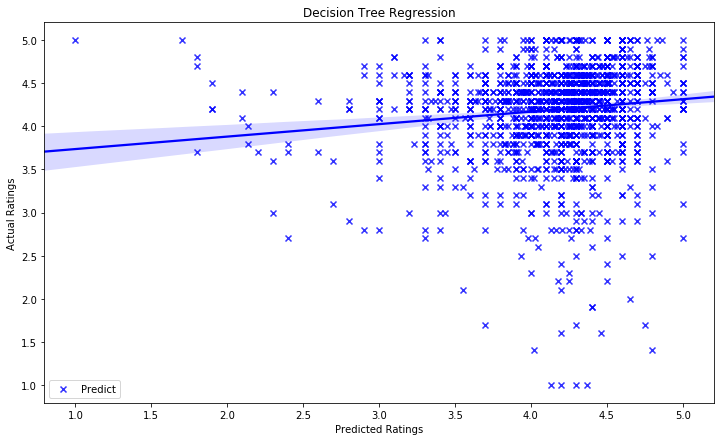

In [23]:
plt.figure(figsize=(12,7))
sns.regplot(Results,y_val,color='blue', label = 'Predict', marker = 'x')
plt.legend()
plt.title('Decision Tree Regression')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()